In [53]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(SeuratData)
    library(CelliD)
    library(readr)
    library(reticulate)
    library(gridExtra)
}))
use_condaenv("Renv")
source_python("/home/vsevim/prj/workflows/ckd/secondary/mixture.py")

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "NO"
}

In [4]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [5]:
h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/Lib_1/seurat_objects/Screen1_66guides_Lib_1.h5seurat"
seurat  <- LoadH5Seurat(h5_path, verbose = FALSE)

Validating h5Seurat file



Use only singlets

In [6]:
seurat_singlets <- subset(seurat, subset = status == 'singlet')

# Call guides using the Poisson-Gaussian Mixture Model

In [7]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL
df_guide_counts$n_guides <- rowSums(df_guide_counts)

In [8]:
head(df_guide_counts)

,CD13-1a,CD13-1b,CD55-1a,CD55-1b,CD73-1a,CD73-1b,FUBP1-1a,FUBP1-1b,C15orf40-1a,C15orf40-1b,⋯,GDOC4-1b,CCCE1-1a,CCCE1-1b,CCCE2-1a,CCCE2-1b,CCCE3-1a,CCCE3-1b,CCCE4-1a,CCCE4-1b,n_guides
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,57,0,⋯,0,0,0,1,0,1,0,0,0,92
2,0,0,0,2,0,0,0,0,1383,0,⋯,0,0,0,0,0,0,0,1,0,1412
3,0,0,0,0,0,0,1,0,1302,1753,⋯,1,0,1,1,0,0,1,2,0,3081
4,0,0,0,0,0,0,0,0,428,1565,⋯,0,0,0,1,0,0,0,0,0,2006
5,0,0,0,0,0,0,0,0,1515,3322,⋯,0,0,0,0,0,0,1,1,0,4873
6,0,0,0,0,0,0,0,0,606,1592,⋯,0,0,0,0,0,0,0,0,0,2212


In [28]:
y = df_guide_counts[,'CD13-1a']
select_nonzeros = y > 0
y = y[select_nonzeros]
log_y = log(y, 2)

In [29]:
calls <- pgmix(y)

In [33]:
df_calls = as.data.frame(calls)
df_calls['counts'] = y
colnames(df_calls) = c('call', 'prob', 'count')

In [34]:
dim(df_calls)
length(y)
head(df_calls)

[1] 1460    3

[1] 1460

,call,prob,count
,<dbl>,<dbl>,<dbl>
1,1,1.3e-08,1
2,1,2.0e-06,2
3,1,1.3e-08,1
4,1,1.3e-08,1
5,1,1.3e-08,1
6,1,1.3e-08,1


,call,prob,count
,<dbl>,<dbl>,<dbl>
1,1,1.3e-08,1
2,1,2.0e-06,2
3,1,1.3e-08,1
4,1,1.3e-08,1
5,1,1.3e-08,1
6,1,1.3e-08,1


[1] 1460    3

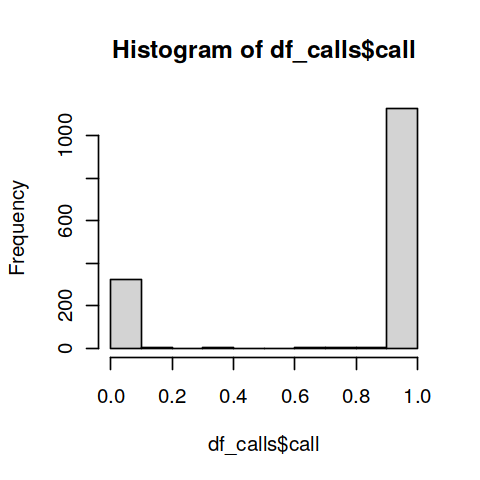

[1] 325   3

threshold= 13

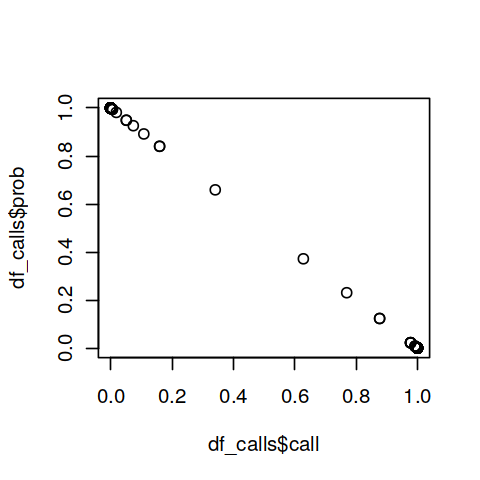

In [38]:
options(repr.plot.width=4, repr.plot.height=4)
CUTOFF_PROB = 0.5
head(df_calls)
dim(df_calls)
select_gaussian_assigned = df_calls[, 'prob'] > CUTOFF_PROB
hist(df_calls$call)
plot(df_calls$call, df_calls$prob)

df_gauss = df_calls[select_gaussian_assigned,]
dim(df_gauss)
 
# head(df_gauss)
threshold = min(df_gauss$count)
cat("threshold=", threshold)

In [39]:
filter_y = y > 2
y_filtered = y[filter_y]
df_y = as.data.frame(y_filtered)
head(df_y)

,y_filtered
,<dbl>
1,4
2,16
3,3
4,3
5,9
6,3


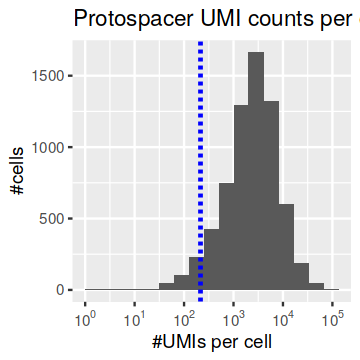

In [47]:
options(repr.plot.width=3, repr.plot.height=3)
bin_breaks <- c(1,2,2*2^(1:16))

ggp1 <- ggplot(df_y, aes(x = y_filtered)) +    # Draw each column as histogram
  geom_histogram(breaks=bin_breaks) + 
  scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
  labs(title="Protospacer UMI counts per cell (log scaled, binned exponentially)", x="#UMIs per cell", y="#cells") +  geom_vline(aes(xintercept=threshold), color="blue", linetype="dashed", size=1)

ggp1

# Call all guides

In [41]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL
df_guide_counts$n_guides <- rowSums(df_guide_counts)

In [42]:
head(df_guide_counts)

,CD13-1a,CD13-1b,CD55-1a,CD55-1b,CD73-1a,CD73-1b,FUBP1-1a,FUBP1-1b,C15orf40-1a,C15orf40-1b,⋯,GDOC4-1b,CCCE1-1a,CCCE1-1b,CCCE2-1a,CCCE2-1b,CCCE3-1a,CCCE3-1b,CCCE4-1a,CCCE4-1b,n_guides
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,57,0,⋯,0,0,0,1,0,1,0,0,0,92
2,0,0,0,2,0,0,0,0,1383,0,⋯,0,0,0,0,0,0,0,1,0,1412
3,0,0,0,0,0,0,1,0,1302,1753,⋯,1,0,1,1,0,0,1,2,0,3081
4,0,0,0,0,0,0,0,0,428,1565,⋯,0,0,0,1,0,0,0,0,0,2006
5,0,0,0,0,0,0,0,0,1515,3322,⋯,0,0,0,0,0,0,1,1,0,4873
6,0,0,0,0,0,0,0,0,606,1592,⋯,0,0,0,0,0,0,0,0,0,2212


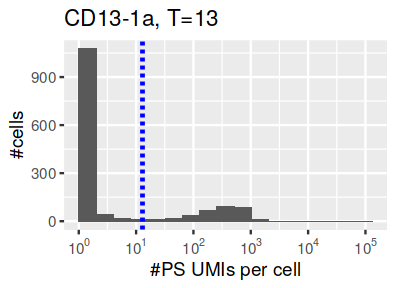

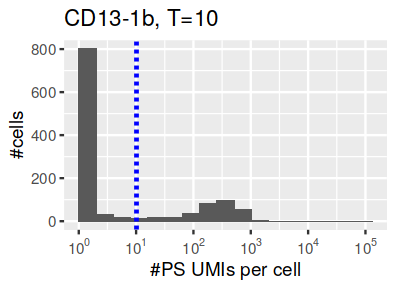

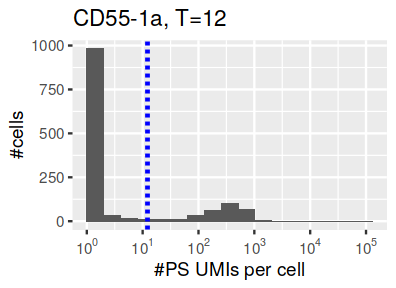

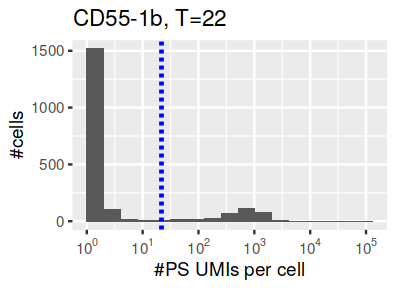

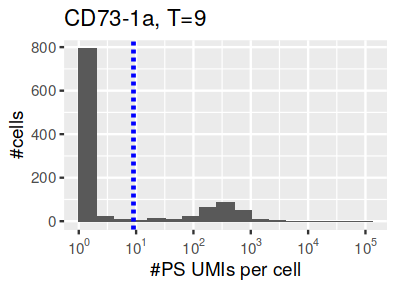

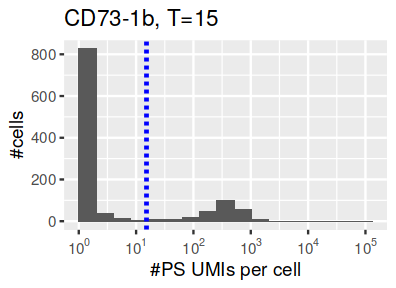

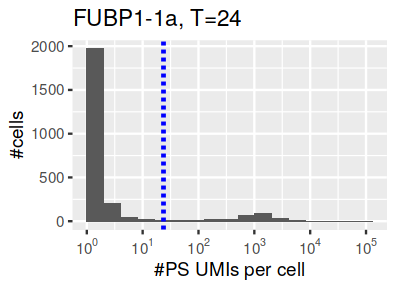

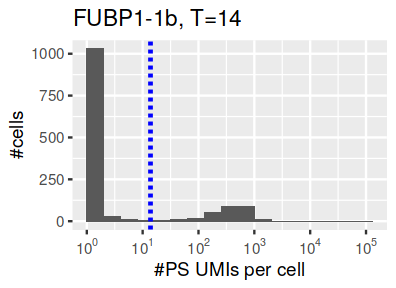

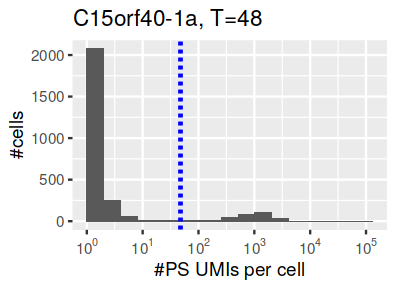

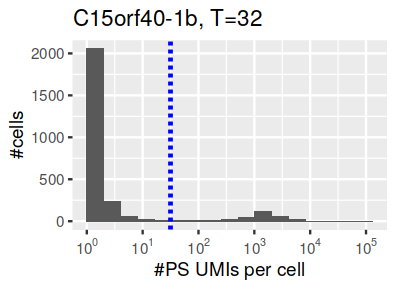

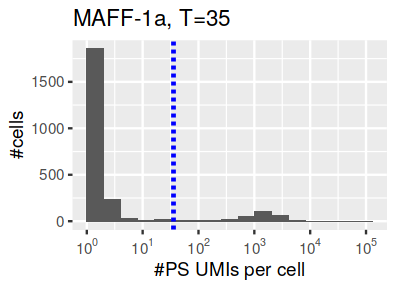

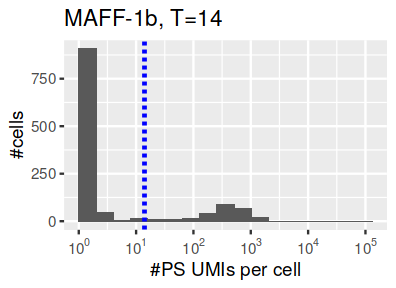

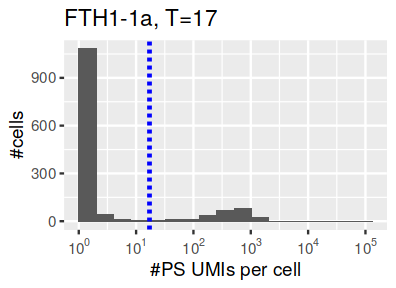

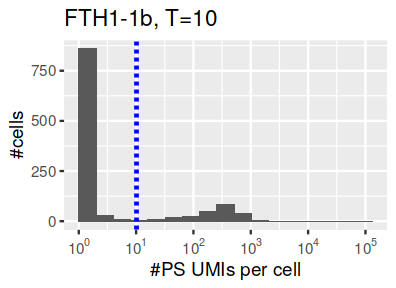

Skipping FTH1-2b 


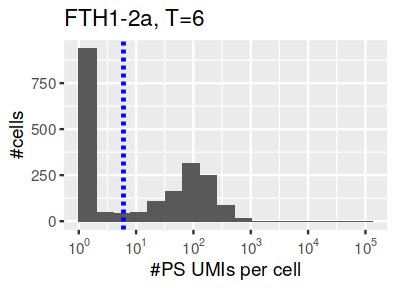

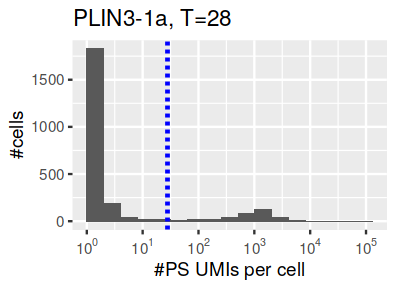

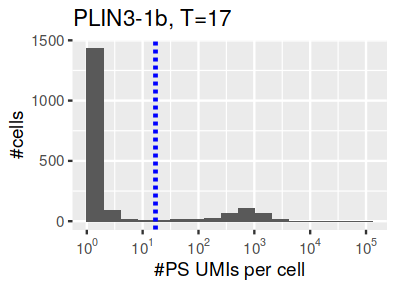

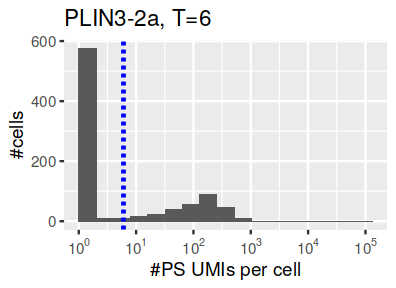

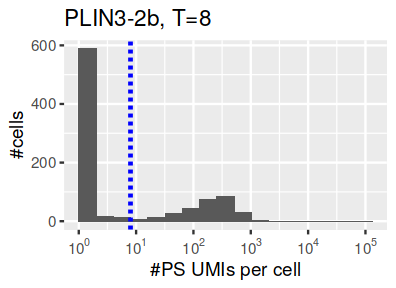

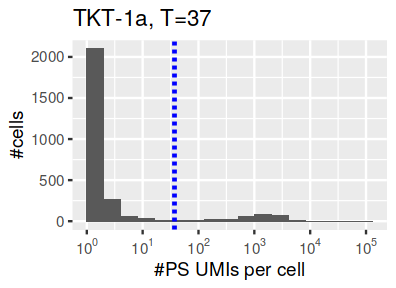

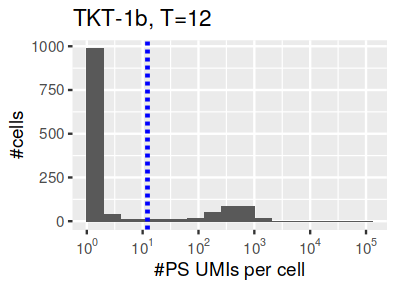

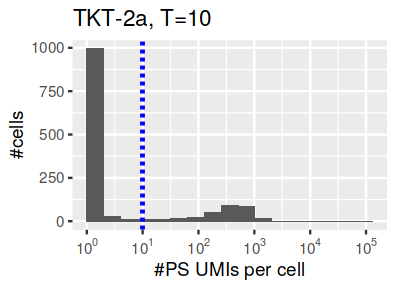

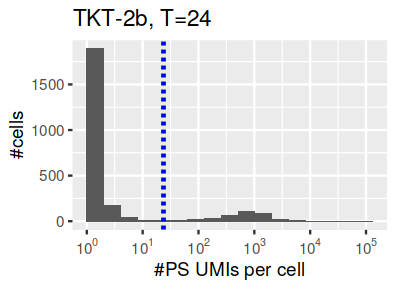

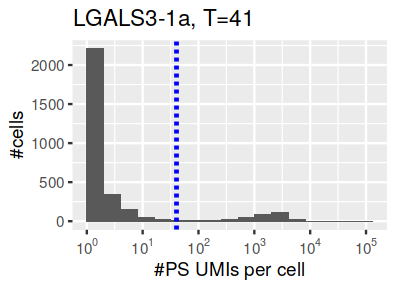

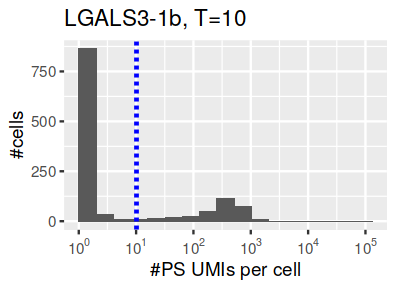

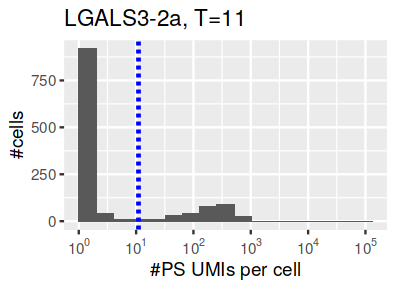

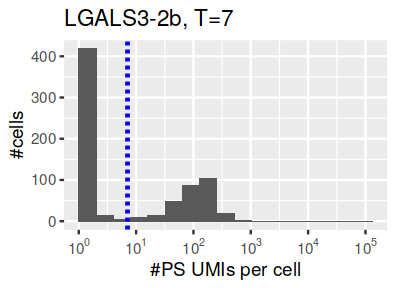

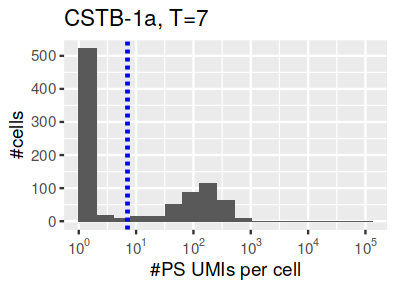

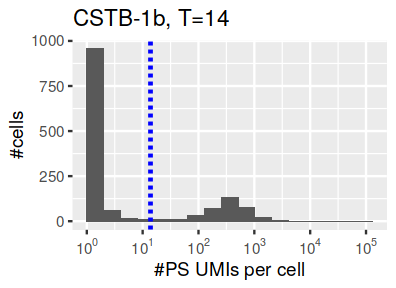

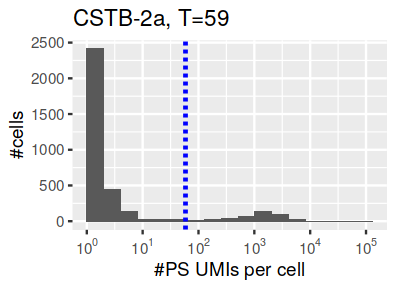

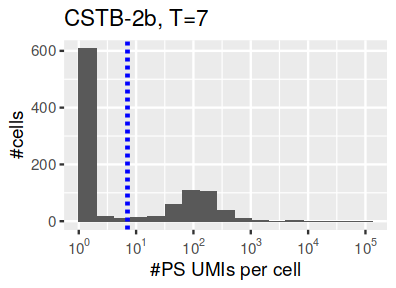

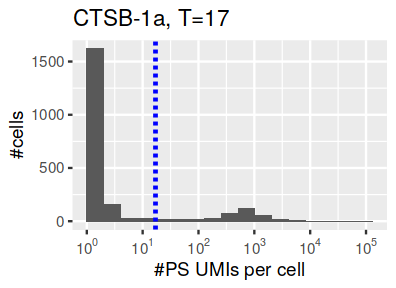

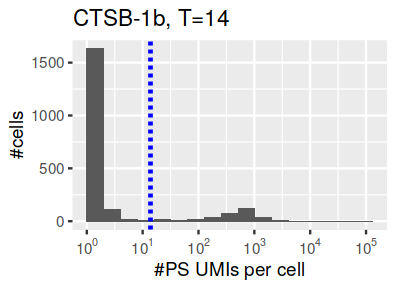

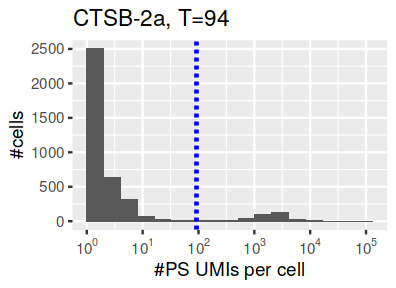

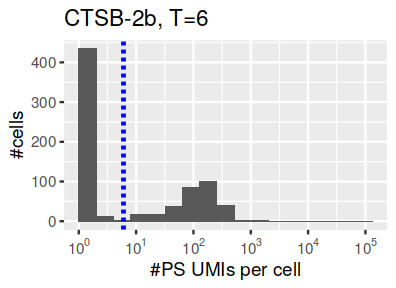

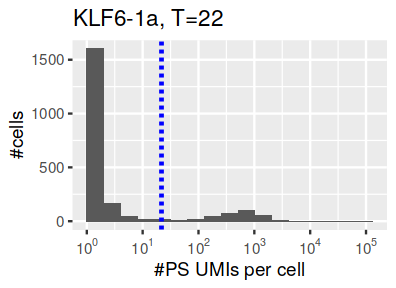

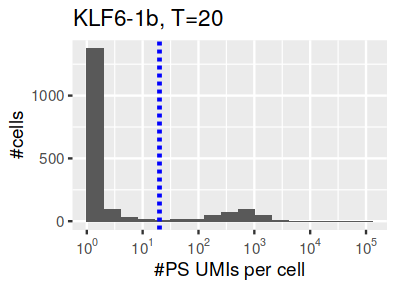

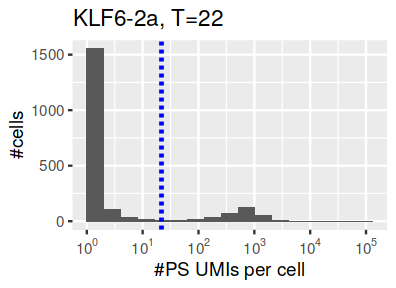

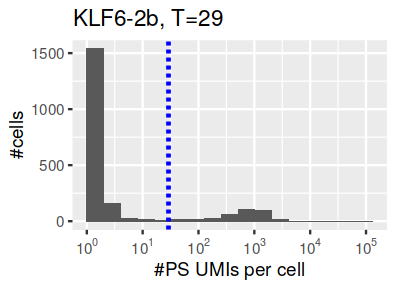

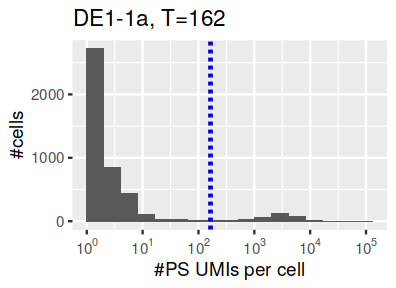

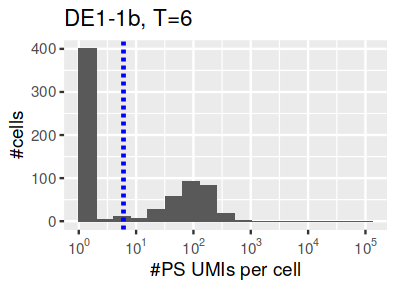

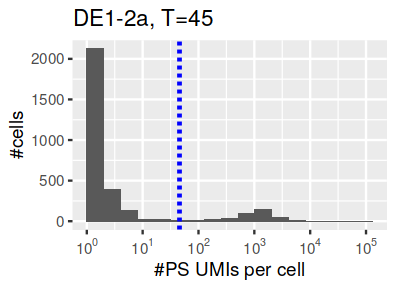

Skipping DE2-1a 
Skipping DE2-1b 


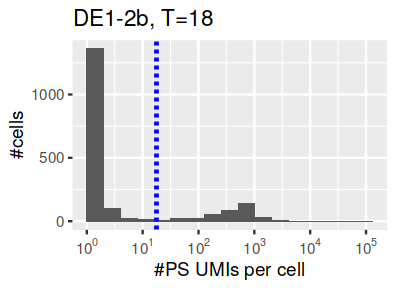

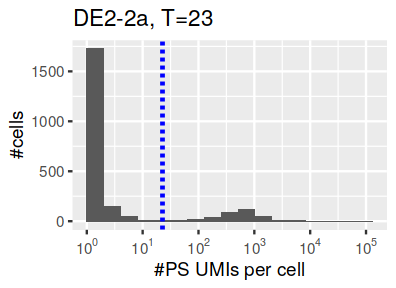

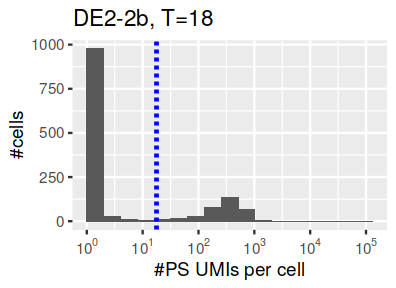

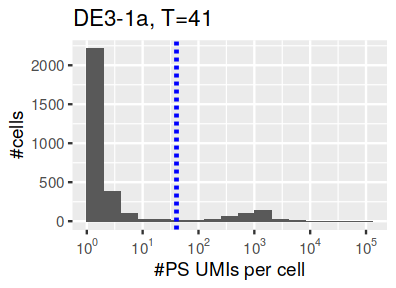

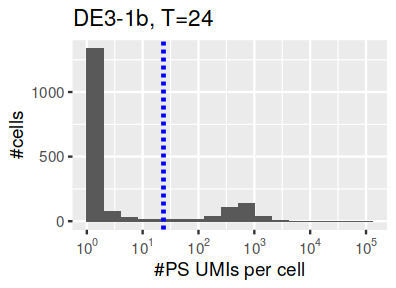

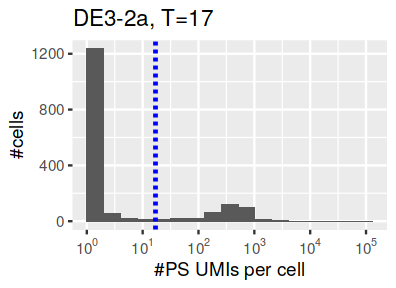

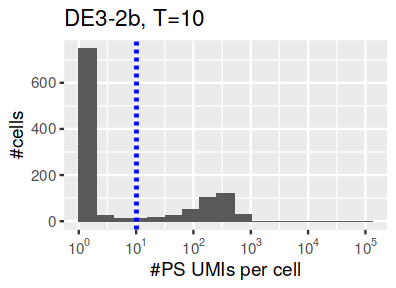

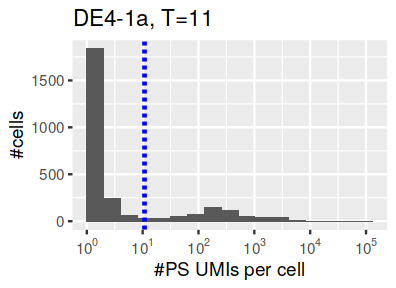

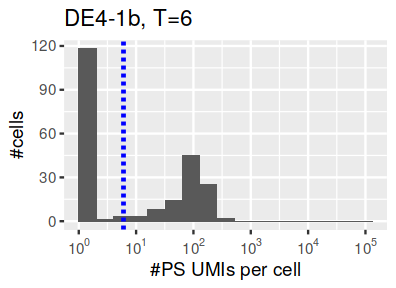

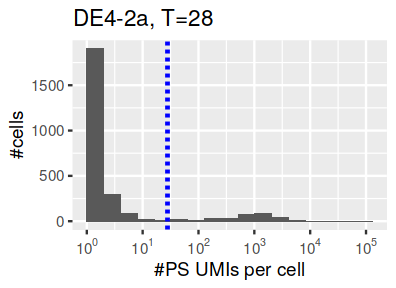

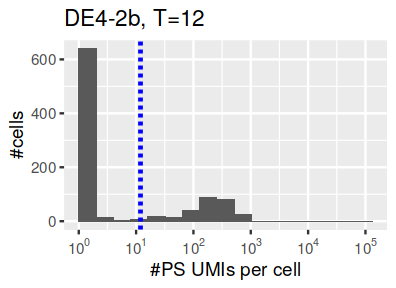

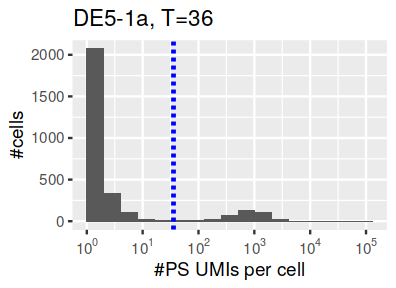

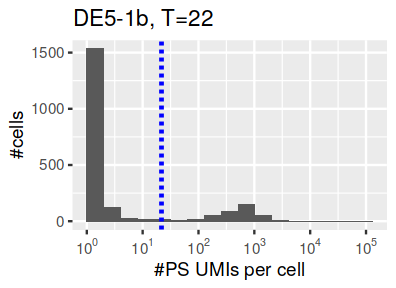

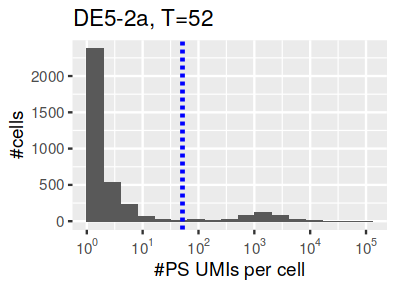

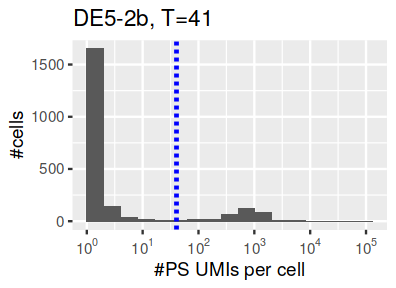

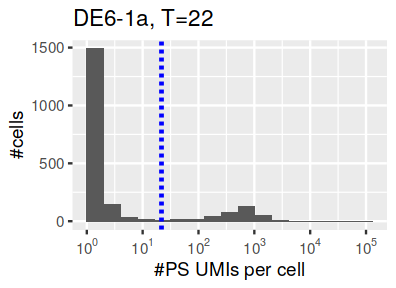

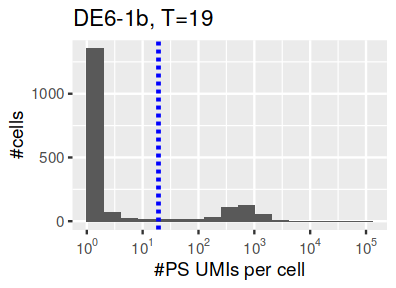

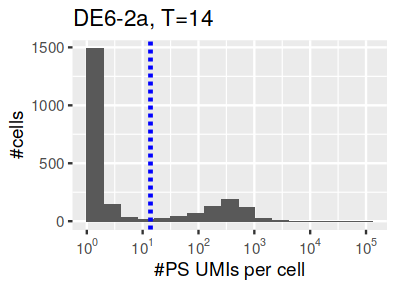

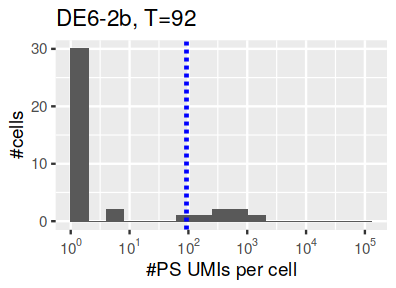

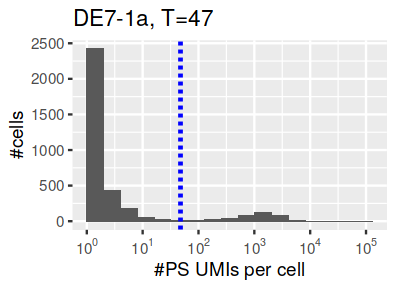

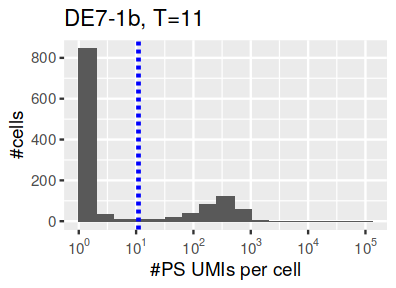

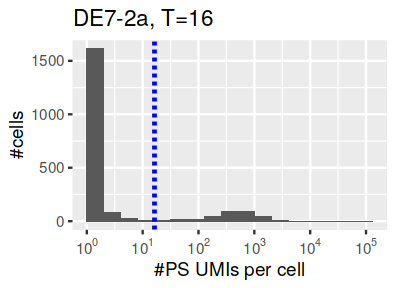

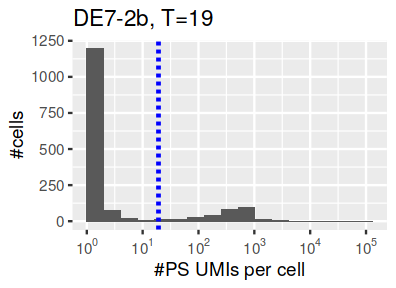

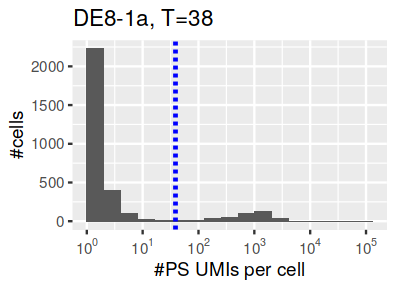

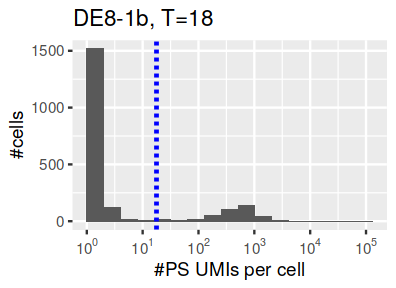

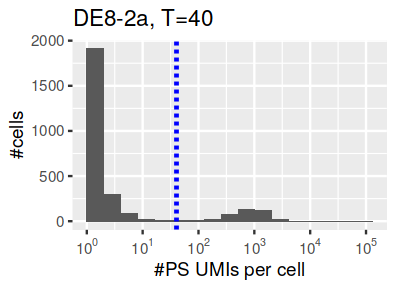

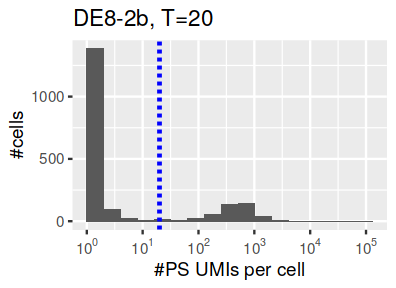

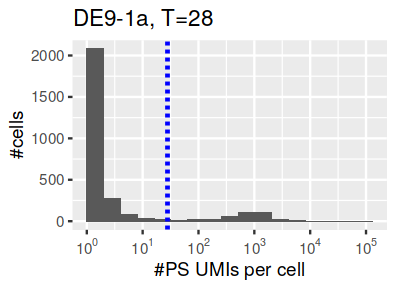

Skipping DE9-2a 
Skipping DE9-2b 


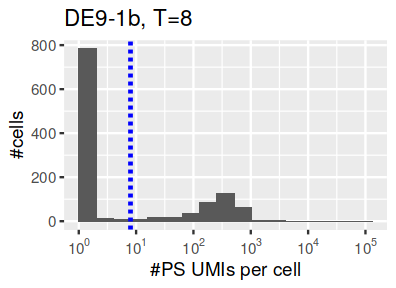

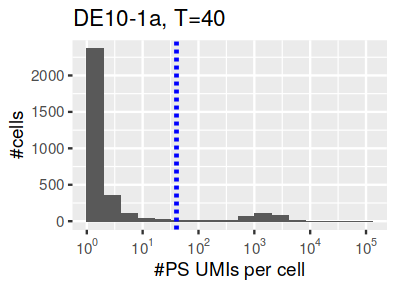

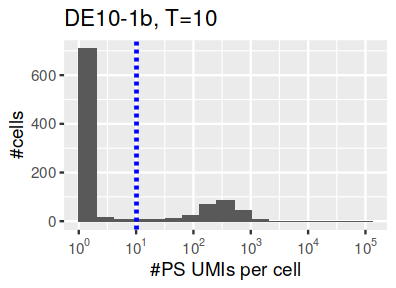

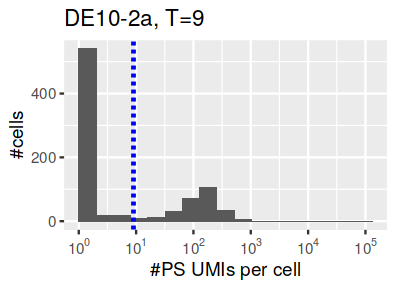

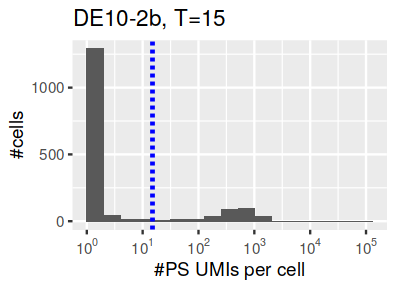

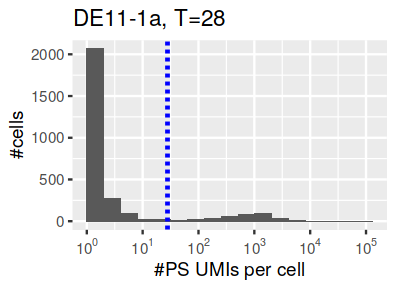

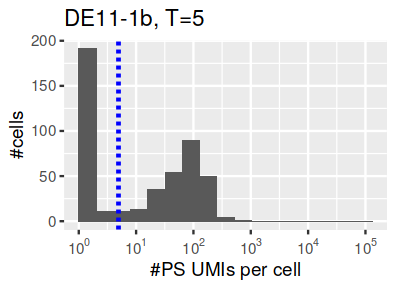

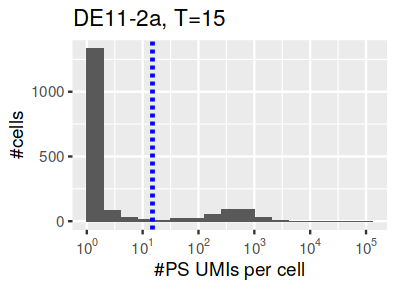

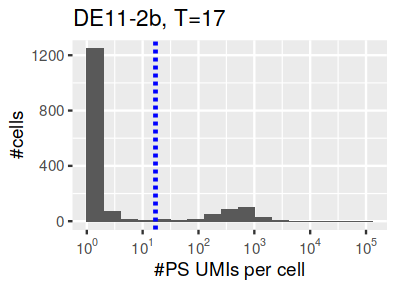

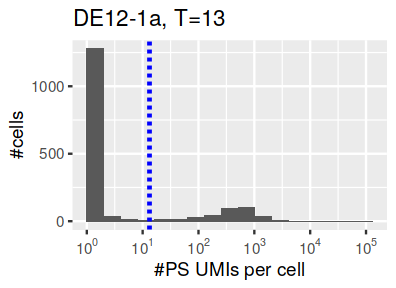

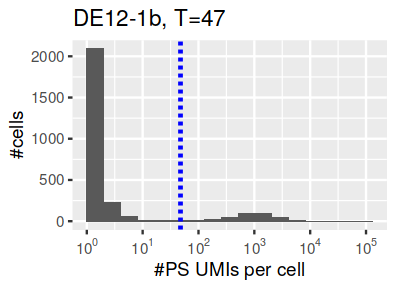

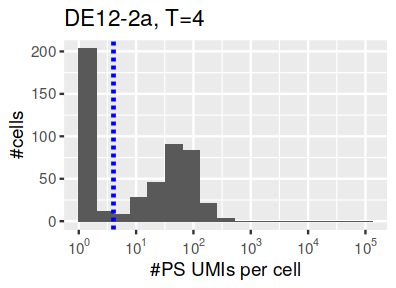

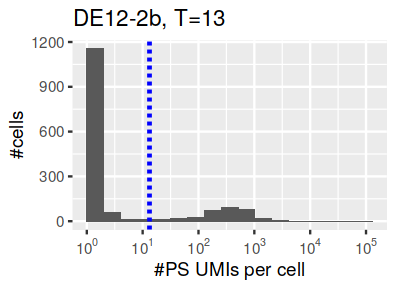

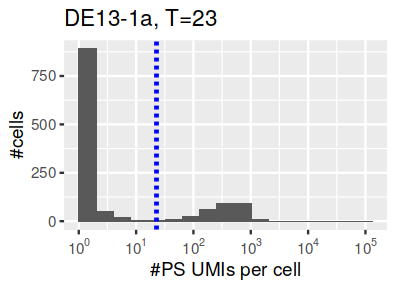

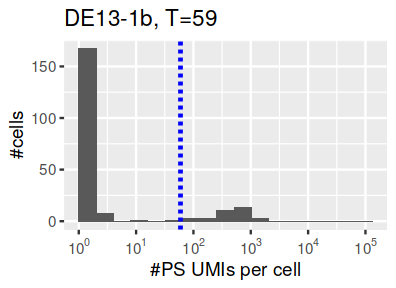

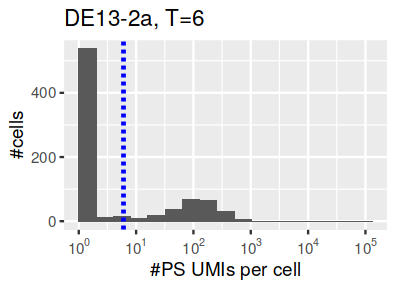

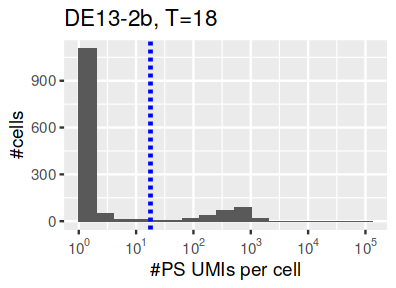

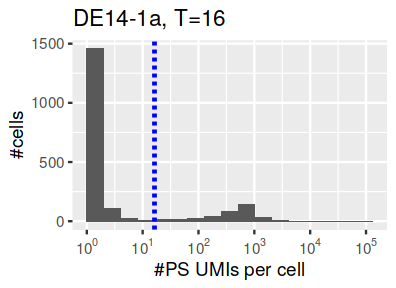

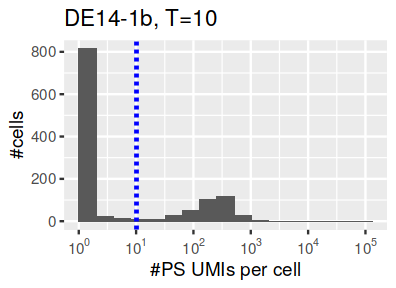

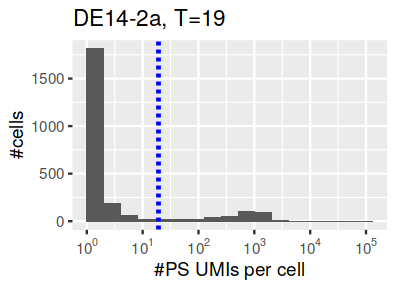

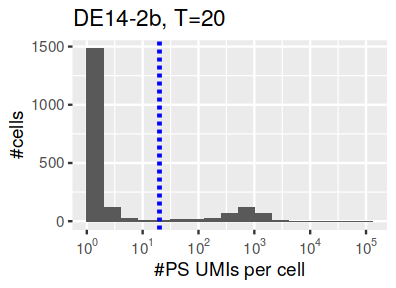

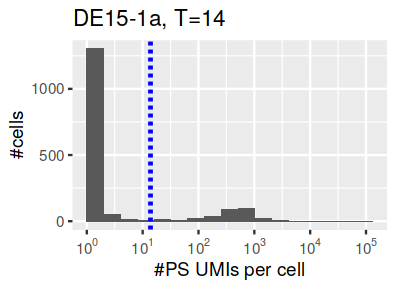

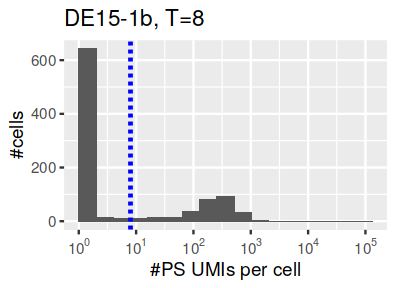

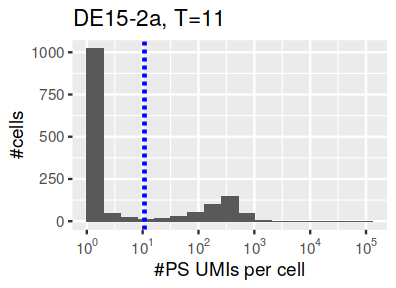

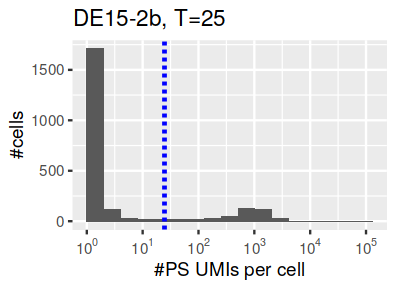

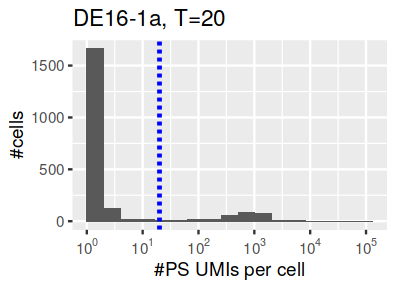

Skipping DE16-2a 


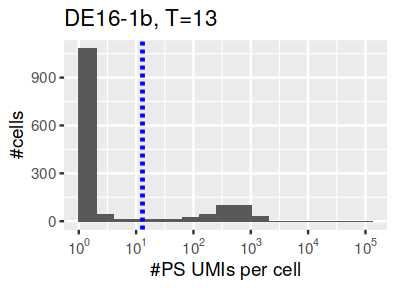

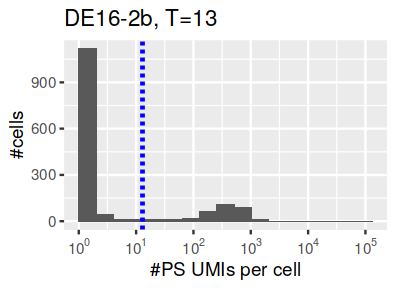

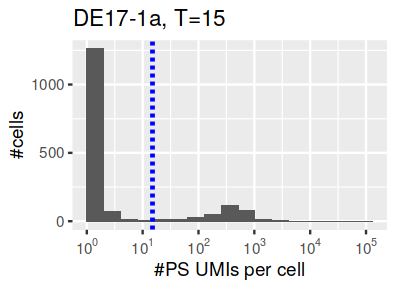

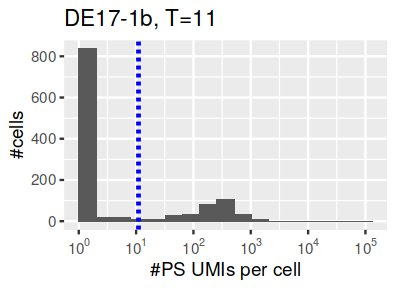

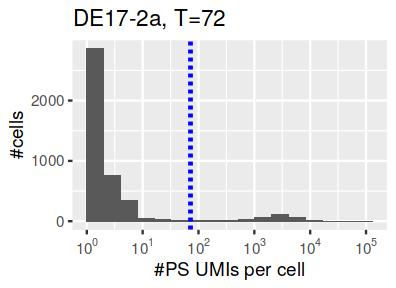

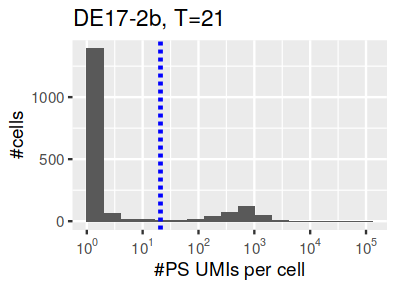

Skipping NTCE1-1b 
Skipping NTCE2-1a 
Skipping NTCE2-1b 


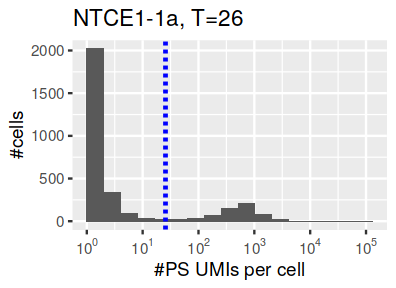

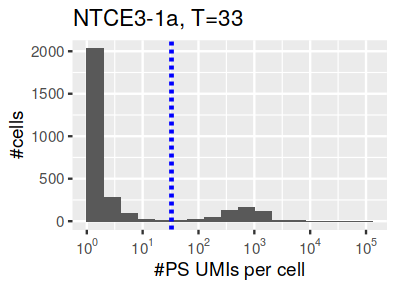

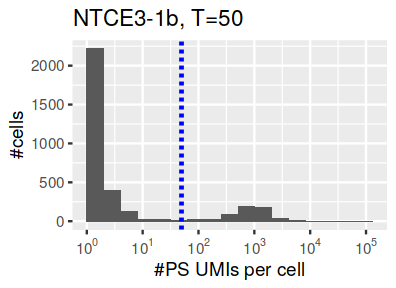

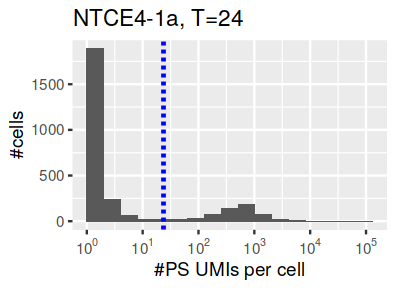

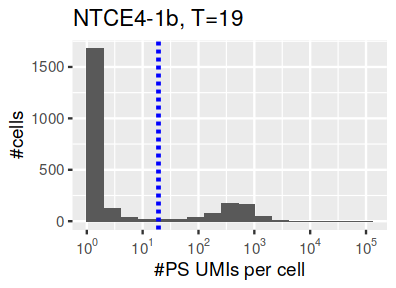

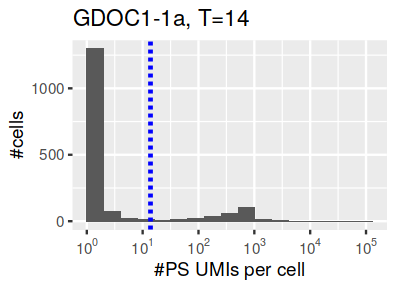

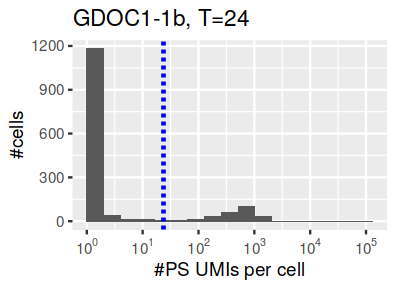

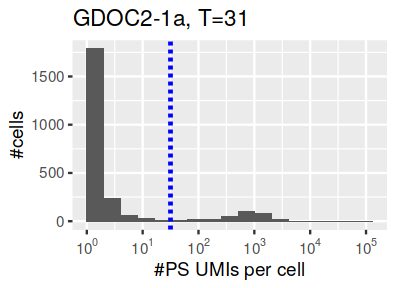

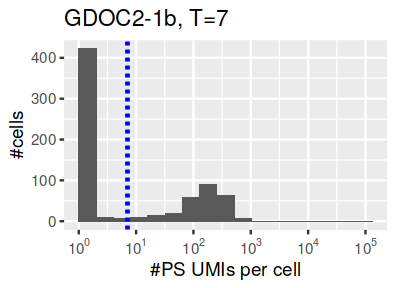

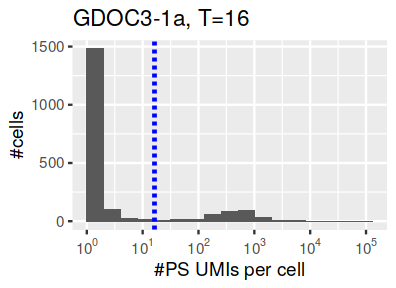

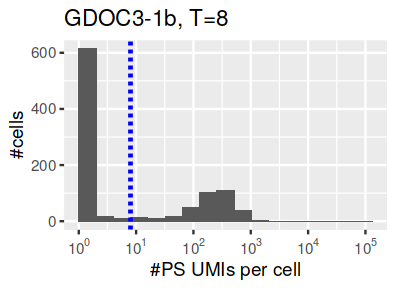

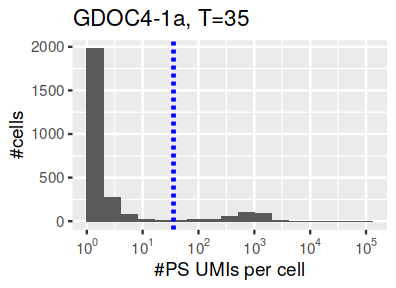

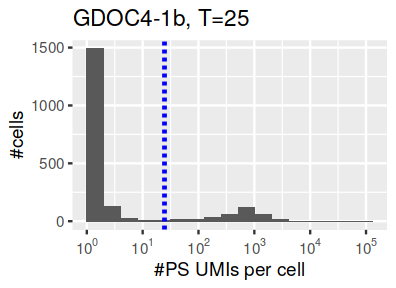

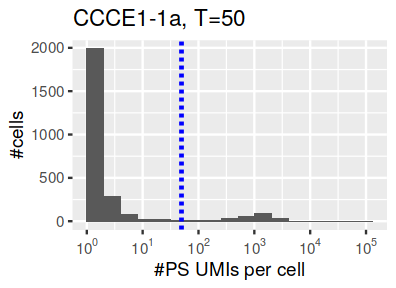

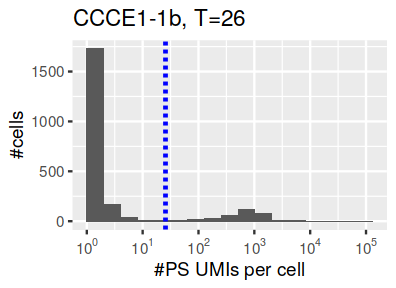

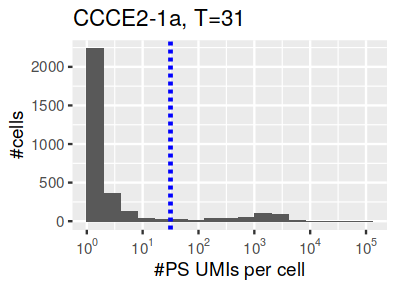

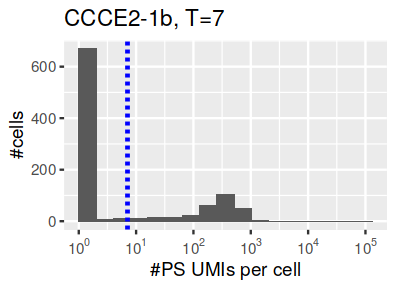

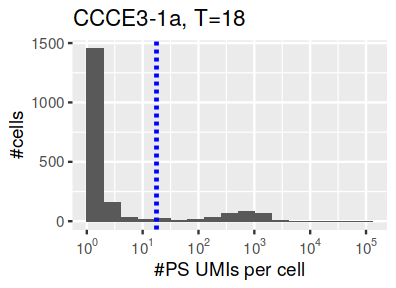

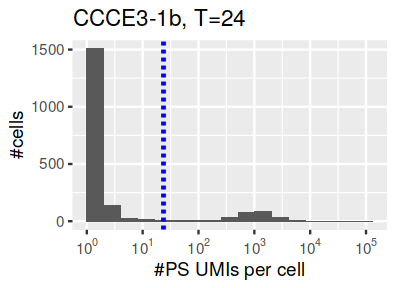

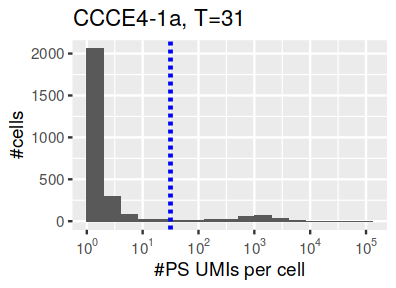

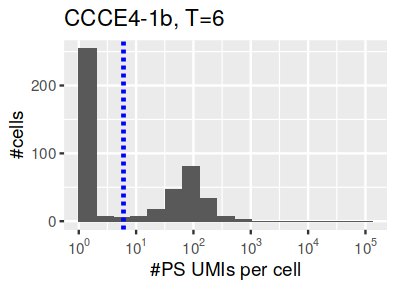

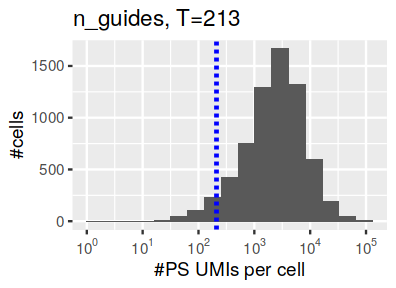

In [67]:
CUTOFF_PROB = 0.5
guides = colnames(df_guide_counts)
plots = list()
i = 1
for(guide in guides) {
    y = df_guide_counts[,guide]
    select_nonzeros = y > 0
    y = y[select_nonzeros]
    if(length(y) == 0) {
        cat("Skipping", guide, "\n")
        next
    }

    calls <- pgmix(y)
    df_calls = as.data.frame(calls)
    df_calls['counts'] = y
    colnames(df_calls) = c('call', 'prob', 'count')
    options(repr.plot.width=4, repr.plot.height=4)
    head(df_calls)
    dim(df_calls)
    select_gaussian_assigned = df_calls[, 'prob'] > CUTOFF_PROB
    # hist(df_calls$call)
    #plot(df_calls$call, df_calls$prob)

    df_gauss = df_calls[select_gaussian_assigned,]
    dim(df_gauss)
    
    # head(df_gauss)
    threshold = min(df_gauss$count)
    #cat("threshold=", threshold)
    filter_y = y > 0
    y_filtered = y[filter_y]
    df_y = as.data.frame(y_filtered)
    head(df_y)
    
    options(repr.plot.width=3.3, repr.plot.height=2.4)
    bin_breaks <- c(1,2,2*2^(1:16))
    title = paste0(guide, ", T=", threshold)

    ggp1 <- ggplot(df_y, aes(x = y_filtered)) +    # Draw each column as histogram
    geom_histogram(breaks=bin_breaks) + 
    scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
    labs(title=title, x="#PS UMIs per cell", y="#cells") +  geom_vline(aes(xintercept=threshold), color="blue", linetype="dashed", size=1)

    #print(ggp1)
    plots[[i]] <- ggp1
    i = i + 1
    print(ggp1)
}

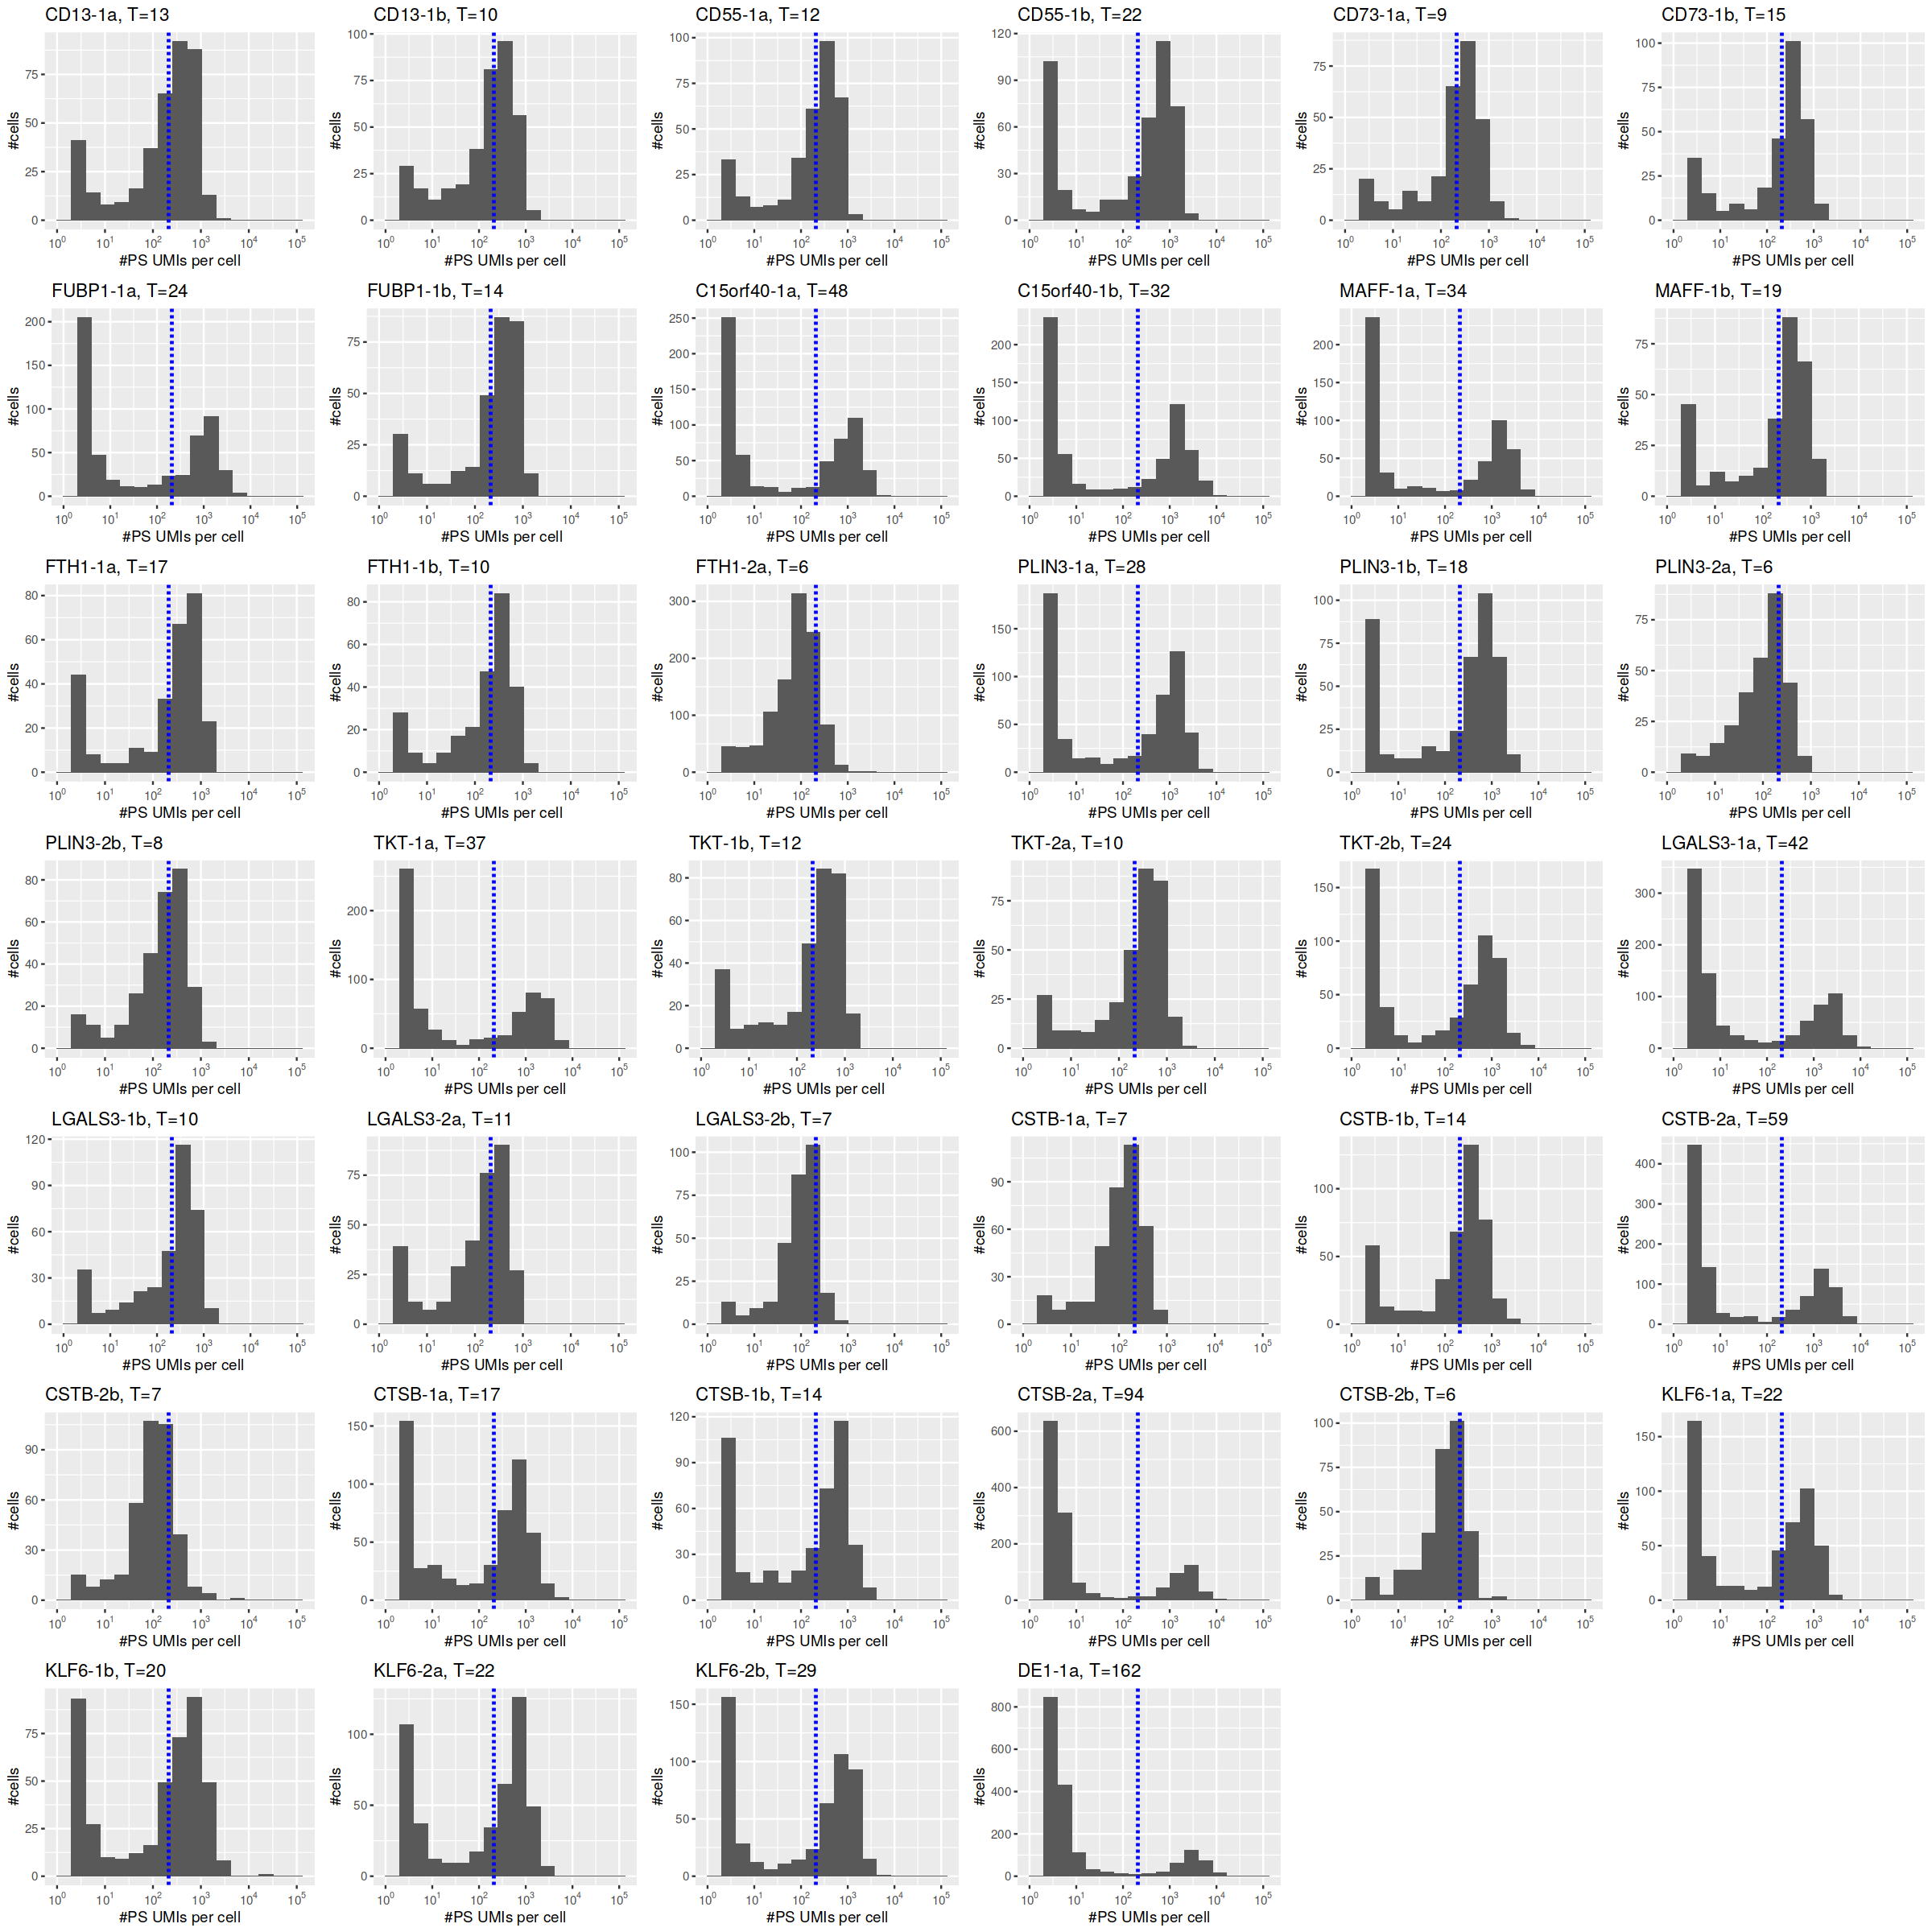

In [64]:
options(repr.plot.width=20, repr.plot.height=20)
do.call(grid.arrange, plots[1:40])